In [1]:
from keras.datasets import cifar100

Using TensorFlow backend.


In [0]:
import os
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate, add, LeakyReLU, ZeroPadding2D, Add, GaussianDropout, merge, AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import RMSprop, adam
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.initializers import glorot_uniform, he_normal, zeros
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import regularizers

#import tensorflow.train.Saver as saver

In [3]:
save_dir = os.path.join(os.getcwd(), 'CIFAR_Model_v2_RESNET_v2')
save_dir_pb = os.path.join(os.getcwd(), 'CIFFAR100_pb_v2_RESNET_v2')
model_name = 'CIFAR100_model_RESNET_v2'
print(save_dir)

from google.colab import drive
drive.mount("/content/drive")

/content/CIFAR_Model_v2_RESNET_v2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data set informations

In [4]:
MODEL_PATH = os.environ.get('MODEL_PATH', 'models/')
CHECKPOINT_PATH = os.environ.get('CHECKPOINT_PATH', 'checkpoints/')
print(MODEL_PATH)

models/


In [0]:
num_classes = 100 ##defined by the dataset

DATA extraction

In [0]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

In [7]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

print(f"Shape y: {y_train.shape}")

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Shape y: (50000, 1)


Convert to binary vectors

In [0]:

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255 ##stanadrization
x_test /= 255 ##standarization

In [9]:
print(f"Shape of y: {y_train.shape}")

Shape of y: (50000, 100)


Training Params

In [0]:
params = {
    "learning_rate" : 0.0001,
    "decay" : 0.0001/50,
    "input_shape" : x_train.shape[1:],
    "output_shape" : num_classes,
    "log_dir" : "/content/saved_models/logs",
    "epochs" : 120,
    "dropout" : 0.2,
    "batch_size" : 128
    
}
weigh_decay = regularizers.l2(0.0005)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



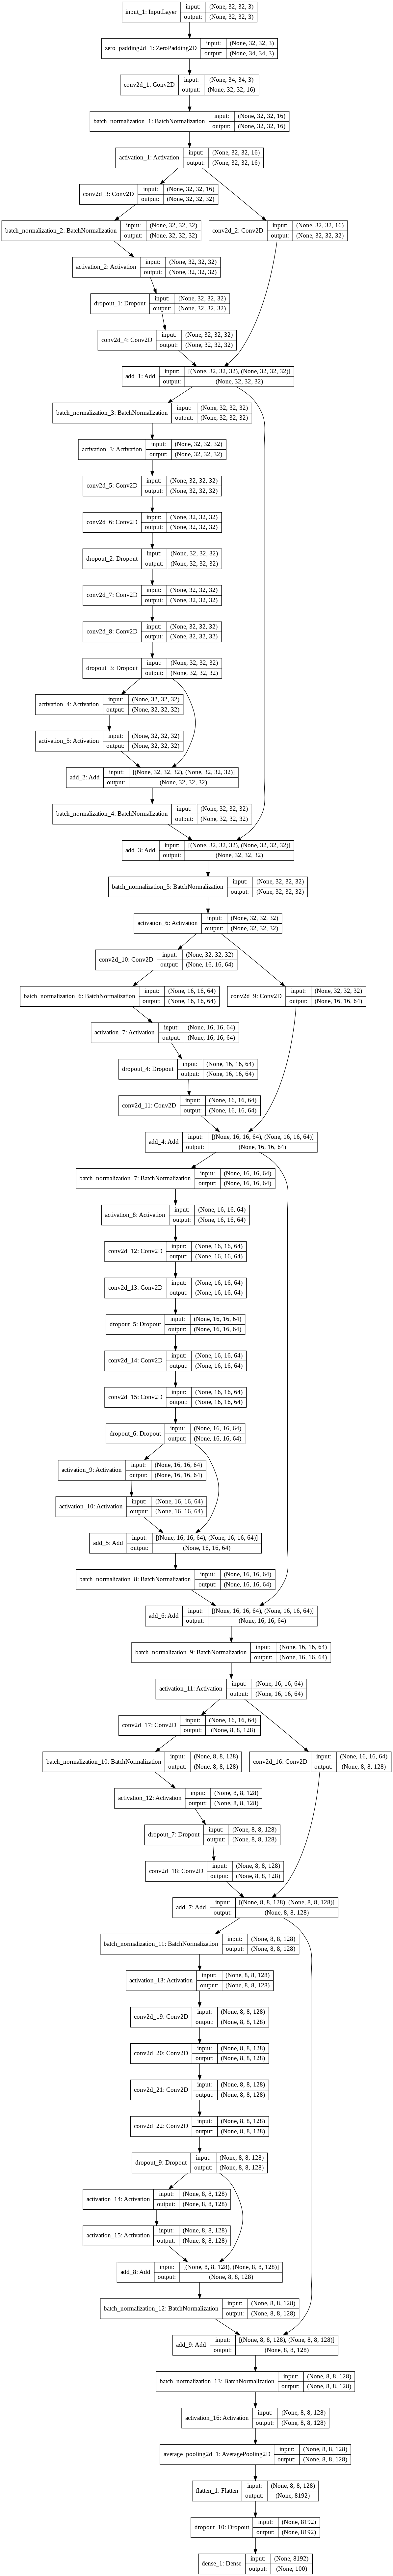

In [11]:
##Res NET

input_img = Input(shape=(32,32,3))
#widening layer
zero_padding_1 = ZeroPadding2D((1,1))(input_img)

conv1 = Conv2D(16, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), kernel_regularizer = weigh_decay)(zero_padding_1)
batch_norm_1 = BatchNormalization()(conv1)
act_1 = Activation("relu")(batch_norm_1)

#first conv brach
conv_branch_2 = Conv2D(32, kernel_size=(1,1), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), kernel_regularizer = weigh_decay)(act_1)

##branch 2
conv_branch_3 = Conv2D(32, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(act_1)
batch_norm_2 = BatchNormalization()(conv_branch_3)
act_2 = Activation("relu")(batch_norm_2)
act_2 = Dropout(0.5)(act_2)
conv_branch_4 = Conv2D(32, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(),padding="same", kernel_regularizer = weigh_decay)(act_2)
#first merge
merge_1 = add([conv_branch_2, conv_branch_4])
## residual layer

short_cut_x = merge_1

batch_norm_4 = BatchNormalization()(merge_1)

act_6 = Activation("relu")(batch_norm_4)

conv_branch_7 = Conv2D(32, kernel_size=(1,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(act_6)
conv_branch_7 = Conv2D(32, kernel_size=(3,1), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(conv_branch_7)
drop = Dropout(0.5)(conv_branch_7)
conv_branch_7 = Conv2D(32, kernel_size=(1,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(drop)
conv_branch_7 = Conv2D(32, kernel_size=(3,1), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(conv_branch_7)
drop = Dropout(0.5)(conv_branch_7)

short_out = drop

act_short_1 = Activation("relu")(drop)
act_short_2 = Activation("sigmoid")(act_short_1)

merge_short = add([act_short_2, drop])

batch_norm_x = BatchNormalization()(merge_short)

merge_4 = add([batch_norm_x, short_cut_x])

#####next steps
batch_norm_5 = BatchNormalization()(merge_4)
act_4 = Activation("relu")(batch_norm_5)

conv_branch_5 = Conv2D(64, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", strides=(2,2), kernel_regularizer = weigh_decay)(act_4)

conv_branch_6 = Conv2D(64, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", strides=(2,2), kernel_regularizer = weigh_decay)(act_4)
batch_norm_5 = BatchNormalization()(conv_branch_6)
act_5 = Activation("relu")(batch_norm_5)
act_5 = Dropout(0.5)(act_5)
conv_branch_6 = Conv2D(64, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(act_5)
#merging
merge_3 = add([conv_branch_5,conv_branch_6])

##residual block
short_cut_x = merge_3

batch_norm_4 = BatchNormalization()(merge_3)

act_6 = Activation("relu")(batch_norm_4)

conv_branch_7 = Conv2D(64, kernel_size=(1,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(act_6)
conv_branch_7 = Conv2D(64, kernel_size=(3,1), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(conv_branch_7)
drop = Dropout(0.5)(conv_branch_7)
conv_branch_7 = Conv2D(64, kernel_size=(1,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(drop)
conv_branch_7 = Conv2D(64, kernel_size=(3,1), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(conv_branch_7)
drop = Dropout(0.3)(conv_branch_7)

short_out = drop

act_short_1 = Activation("relu")(drop)
act_short_2 = Activation("sigmoid")(act_short_1)

merge_short = add([act_short_2, drop])

batch_norm_x = BatchNormalization()(merge_short)

merge_4 = add([batch_norm_x, short_cut_x])

###next steps..
batch_norm_6 = BatchNormalization()(merge_4)
act_8 = Activation("relu")(batch_norm_6)

conv_branch_9 = Conv2D(128, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", strides=(2,2), kernel_regularizer = weigh_decay)(act_8)

conv_branch_10 = Conv2D(128, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", strides=(2,2), kernel_regularizer = weigh_decay)(act_8)
batch_norm_7 = BatchNormalization()(conv_branch_10)
act_9 = Activation("relu")(batch_norm_7)
act_9 = Dropout(0.5)(act_9)
conv_branch_11 = Conv2D(128, kernel_size=(3,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(act_9)
#merging
merge_5 = add([conv_branch_11,conv_branch_9])

###Residual Block

##residual block
short_cut_x = merge_5

batch_norm_4 = BatchNormalization()(merge_5)

act_6 = Activation("relu")(batch_norm_4)

conv_branch_7 = Conv2D(128, kernel_size=(1,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(act_6)
conv_branch_7 = Conv2D(128, kernel_size=(3,1), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(conv_branch_7)
drop = Dropout(0.5)(conv_branch_7)
conv_branch_7 = Conv2D(128, kernel_size=(1,3), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(conv_branch_7)
conv_branch_7 = Conv2D(128, kernel_size=(3,1), kernel_initializer=he_normal(seed=0), use_bias=True, bias_initializer=zeros(), padding="same", kernel_regularizer = weigh_decay)(conv_branch_7)
drop = Dropout(0.3)(conv_branch_7)

short_out = drop

act_short_1 = Activation("relu")(drop)
act_short_2 = Activation("sigmoid")(act_short_1)

merge_short = add([act_short_2, drop])

batch_norm_x = BatchNormalization()(merge_short)

merge_6 = add([batch_norm_x, short_cut_x])



#####Flattening model
batch_norm_final = BatchNormalization()(merge_6)
act_final = Activation("relu")(batch_norm_final)
pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1),  padding="same")(act_final)
flatten = Flatten()(pool)
drop = Dropout(0.5)(flatten)
output = Dense(num_classes, activation='softmax', use_bias=True, kernel_initializer=he_normal(seed=0), bias_initializer=zeros(),kernel_regularizer = weigh_decay)(drop)

##plot model
model = Model([input_img], output)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [0]:

lr_schedule = [20,80,160] # epoch_step
def schedule(epoch_idx):
    if (epoch_idx + 1) < lr_schedule[0]:
        return 0.0002
    elif (epoch_idx + 1) < lr_schedule[1]:
        return 0.0002*0.6 # lr_decay_ratio = 0.2
    elif (epoch_idx + 1) < lr_schedule[2]:
        return 0.0002*0.2
    return 0.00008

In [13]:
##compile model
tensorboard = TensorBoard(log_dir=params["log_dir"], histogram_freq=0, write_graph=True, write_images=False)

#opt = RMSprop(lr=params["learning_rate"], decay=params["decay"])
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy', 'categorical_accuracy'])
model.summary()




Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
___________________________________________________________________________________________

In [0]:
from keras.callbacks import Callback
class WeightsSaver(Callback):
  def __init__(self, N):
    self.N = N
    self.epoch = 0

  def on_epoch_end(self, epoch, logs={}):
    if self.epoch % self.N == 0:
      name = 'weights%08d.h5' % self.epoch
      self.model.save_weights(name)
    self.epoch += 1

In [15]:
datagen = ImageDataGenerator(
    featurewise_center=True,#et input mean to 0 over the dataset
    samplewise_center=True,# set each sample mean to 0
    featurewise_std_normalization=True, #divide inputs by std of the dataset
    samplewise_std_normalization=True,  # divide each input by its std
    zca_whitening=True, #apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0.2, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.2,  # set range for random shear
    zoom_range=0.2,  # set range for random zoom
    channel_shift_range=0.2,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:341: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [16]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
                    verbose=1,
                    batch_size=128,
                    epochs=params["epochs"], 
                    callbacks=[tensorboard, WeightsSaver(5), LearningRateScheduler(schedule=schedule)], 
                    shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 50000 samples, validate on 10000 samples


Epoch 1/120
50000/50000 [==============================] - 74s 1ms/step - loss: 5.7927 - acc: 0.0622 - categorical_accuracy: 0.0622 - val_loss: 5.5077 - val_acc: 0.0888 - val_categorical_accuracy: 0.0888
Epoch 2/120
50000/50000 [==============================] - 70s 1ms/step - loss: 5.1064 - acc: 0.1259 - categorical_accuracy: 0.1259 - val_loss: 4.9658 - val_acc: 0.1428 - val_categorical_accuracy: 0.1428
Epoch 3/120
50000/50000 [==============================] - 70s 1ms/step - loss: 4.7015 - acc: 0.1707 - categorical_accuracy: 0.1707 - val_loss: 4.5172 - val_acc: 0.2020 - val_categorical_accuracy: 0.2020
Epoch 4/120
50000/50000 [==============================] - 70s 1ms/step - loss: 4.3634 - acc: 0.2108 - categorical_accuracy: 0.2108 - val_loss: 4.2960 - val_acc: 0.2243 - val_categorical_accuracy: 0.2243
Epoch 5/120
50000/50000 [=============

In [17]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)  

Saved trained model at /content/CIFAR_Model_v2_RESNET_v2/CIFAR100_model_RESNET_v2 


In [0]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=None):
  """
  @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
  """
  from tensorflow.python.framework.graph_util import convert_variables_to_constants
  
  graph = session.graph
  with graph.as_default():
    freeze_var_names = list(set(v.op.name for v in tf.global_variables())
                            .difference(keep_var_names or []))
    output_names = output_names or []
    output_names += [v.op.name for v in tf.global_variables()]
    input_graph_def = graph.as_graph_def()
    
    if clear_devices:
      for node in input_graph_def.node:
        node.device = ""
    frozen_graph = convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
    
    return frozen_graph

In [30]:
frozen_graph = freeze_session(K.get_session(),
                             output_names=[out.op.name for out in model.outputs])
x = tf.train.write_graph(frozen_graph, save_dir_pb, "CIFAR_Model_v2_RESNET", as_text=False)

INFO:tensorflow:Froze 371 variables.
INFO:tensorflow:Converted 371 variables to const ops.


In [29]:
save_dir_pb

'/content/CIFFAR100_pb_v2_RESNET_v2'

In [0]:
from google.colab import files
with open(x, "w") as f:
  f.write("CIFFAR100_pb_file")
files.download(x)

In [0]:
from google.colab import files
pb_file = files.download("/content/CIFFAR100_pb_v2_RESNET_v2/CIFAR_Model_v2_RESNET")